In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from PIL import Image
import sys
import os
import pandas as pd
sys.path.append(r'../Data/')
from dataloader import Data

In [2]:
def plotLosses(model_save_path):
    
    # Find csv
    files = os.listdir(model_save_path)
    csv_file = [file for file in files if ".csv" in file][0] 
    loss = pd.read_csv(os.path.join(model_save_path, csv_file))
    
    plt.title("Training Loss Curve")
    plt.plot(loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    return loss
    

In [4]:
def longestSubstringFinder(string1, string2):
    answer = ""
    len1, len2 = len(string1), len(string2)
    for i in range(len1):
        match = ""
        for j in range(len2):
            if (i + j < len1 and string1[i + j] == string2[j]):
                match += string2[j]
            else:
                if (len(match) > len(answer)): answer = match
                match = ""
    return answer

def getUniqueBtwStrings(strings):
    
    common_factor = longestSubstringFinder(strings[0], strings[1])
    unique = []
    for string in strings:
        r = string.replace(common_factor, "").replace("_epoch", "")
        unique.append(int(r))
    return unique

def findBs(string):
    end_idx = string.find("_bs")
    return int(string[:end_idx])

def getAccuracy(model, data_loader, use_cuda):

    cor = 0
    total = 0
    n = 0
    for imgs, labels in data_loader:
        imgs = torch.from_numpy(imgs.detach().numpy())
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
        #############################################
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        cor = cor + pred.eq(labels.view_as(pred)).sum().item()
        total = total + imgs.shape[0]
        n = n+1
    return cor / total

def plotAccuracy(model_class, model_save_path, val_dataset, train_dataset = None, use_cuda = False):
    
    model_dicts = [file for file in os.listdir(model_save_path) if ".csv" not in file]
    if train_dataset:
        t_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=findBs(model_dicts[0]))
    v_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
    epochs = dict(zip(getUniqueBtwStrings(model_dicts), [[] for i in getUniqueBtwStrings(model_dicts)]))
    i = 0
    
#     for each model dict, create model
    for model_params,epoch in zip(model_dicts, epochs):
        print(i)
        # load model
        model = model_class()
        checkpoint = torch.load(os.path.join(model_save_path, model_params))
        model.load_state_dict(checkpoint)
        # get acc for model and append
        if train_dataset:
            epochs[epoch].append(getAccuracy(model, t_data_loader, use_cuda))
        else:
            epochs[epoch].append(None)
        epochs[epoch].append(getAccuracy(model, v_data_loader, use_cuda))
        i+=1
    
    # Plot    
    
    sorted_epochs = {i:epochs[i] for i in sorted(epochs)}
    
    plt.title("Accuracy Curves")
    plt.plot([i for i in sorted_epochs], [sorted_epochs[i][0] for i in sorted_epochs], label="Train")
    plt.plot([i for i in sorted_epochs], [sorted_epochs[i][1] for i in sorted_epochs], label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show() 

In [42]:
print("Train...")

training_folders = [
    "../Data/Processed/train/epidural",
    "../Data/Processed/train/intraparenchymal",
    "../Data/Processed/train/subarachnoid",
    "../Data/Processed/train/intraventricular",
    "../Data/Processed/train/subdural",
    "../Data/Processed/train/nohem",
]

train_data = Data(training_folders, {
    "epidural":"any", 
    "intraparenchymal":"any", 
    "subarachnoid":"any", 
    "intraventricular":"any", 
    "subdural":"any", 
}, 100, 256)

print("Val....")

val_folders = [
    "../Data/Processed/val/epidural",
    "../Data/Processed/val/intraparenchymal",
    "../Data/Processed/val/subarachnoid",
    "../Data/Processed/val/intraventricular",
    "../Data/Processed/val/subdural",
    "../Data/Processed/val/nohem",
]

val_data = Data(val_folders, {
    "epidural":"any", 
    "intraparenchymal":"any", 
    "subarachnoid":"any", 
    "intraventricular":"any", 
    "subdural":"any", 
}, 50, False)

Train...
Unpacking epidural
Unpacking intraparenchymal
Unpacking subarachnoid
Unpacking intraventricular
Unpacking subdural
Unpacking nohem
Val....
Unpacking epidural
Unpacking intraparenchymal
Unpacking subarachnoid
Unpacking intraventricular
Unpacking subdural
Unpacking nohem


# Overfit

In [16]:
import torch.nn as nn
import torchvision.models

# from Full_detector_training import HemorrhageDetector

alexnet_model = torchvision.models.alexnet(pretrained=True)
alexnet_model.features[0] = nn.Conv2d(1, 64, kernel_size= 7, stride= 2, padding= 3)

class HemorrhageDetector(nn.Module):
    def __init__(self):
        super(HemorrhageDetector, self).__init__()
        self.name = "Detector"

        for param in alexnet_model.parameters():
              param.requires_grad = False

        self.fc1 = nn.Linear(256*31*31, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = alexnet_model.features(x)
#         print(x.shape)
        x = x.view(-1, 256*31*31)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

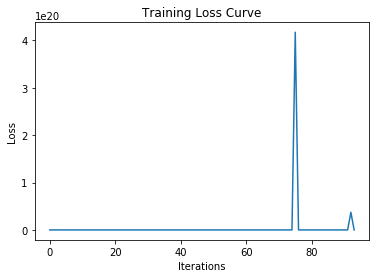

,1.043893583118915558e-02
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
374,NaN
375,NaN
376,NaN
377,NaN


In [5]:
plotLosses("Model_resizing_test_complex_bs=32")

Val....
Unpacking epidural
Unpacking intraparenchymal
Unpacking subarachnoid
Unpacking intraventricular
Unpacking subdural
Unpacking nohem
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


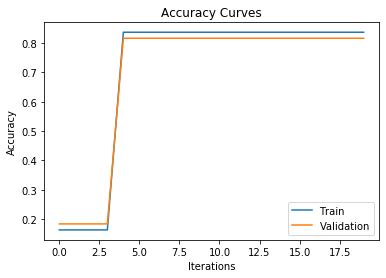

In [43]:
print("Val....")

val_folders = [
    "../Data/Processed/val/epidural",
    "../Data/Processed/val/intraparenchymal",
    "../Data/Processed/val/subarachnoid",
    "../Data/Processed/val/intraventricular",
    "../Data/Processed/val/subdural",
    "../Data/Processed/val/nohem",
]

val_data = Data(val_folders, {
    "epidural":"any", 
    "intraparenchymal":"any", 
    "subarachnoid":"any", 
    "intraventricular":"any", 
    "subdural":"any", 
}, 10, False)

plotAccuracy(HemorrhageDetector, "Model_Overfit_detector_Alex", train_dataset=train_data, val_dataset=val_data)

# 27k

In [10]:
# plotLosses("Model_27k_detector_Alex")
# ! ls Model_27k_detector_Alex

0
1
2
3
4
5
6
7
8


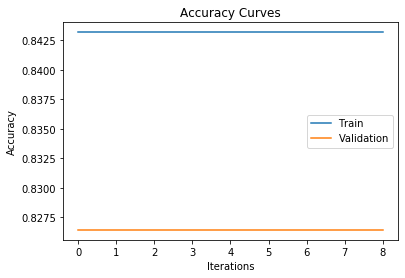

In [22]:
plotAccuracy(HemorrhageDetector, "Model_27k_detector_Alex", val_data, train_dataset=train_data)